In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class Simulation:
    def __init__(self, candidat, n_compas:int, n_voters:int, D:int, path_to_params: str = ''):
        self.n_compas = n_compas
        self.n_voters = n_voters
        self.candidat = candidat
        self.n_candidat = np.shape(candidat)[0]
        self.df = pd.read_parquet(path_to_params+f'parametry_beta_D{D}_n{n_compas}.parquet')
        self.compas = self.generate_compas()
        self.dist = self.distances()

    def generate_compas(self):
        a = self.df['a'].to_numpy().reshape(-1, 1)
        b = self.df['b'].to_numpy().reshape(-1, 1)
        C = np.array([np.dstack((i, j))[0] for j in 
                      np.random.beta(a, b, size=(self.n_compas, self.n_voters)) for i in 
                      np.random.beta(a, b, size=(self.n_compas, self.n_voters))]).astype(np.float16)
        return C
            
    def distances(self):
        one_matrix = np.reshape(self.compas, (self.n_compas**2*self.n_voters, 2)).astype(np.float16)
        return cdist(one_matrix, self.candidat, metric='euclidean').reshape(self.n_compas**2, self.n_voters, self.n_candidat).astype(np.float16)
    
    def system(self, system):
        result = np.array([system(city, self) for city in self.dist])
        return np.reshape(result, (self.n_compas, self.n_compas))

    def optimal_win_plot(self):
        opt_compas= np.array([np.array([i, j]) 
                    for j in self.df['true_value'] 
                    for i in self.df['true_value']])
        optwin = np.argmin(cdist(opt_compas, self.candidat), axis=1).reshape(self.n_compas, self.n_compas)
        candidat_plot = (self.candidat)*self.n_compas
        
        cmap = plt.cm.viridis
        norm = plt.Normalize(vmin=0, vmax=self.n_candidat-1)
        col = cmap(norm(np.arange(self.n_candidat)))
        plt.rc('font', family='serif')
        plt.matshow(optwin, origin = "lower")
        plt.yticks((np.linspace(0, 1, num=6))*(self.n_compas-1), (0. , 0.2, 0.4, 0.6, 0.8, 1))
        plt.xticks((np.linspace(0, 1, num=6))*(self.n_compas-1), (0. , 0.2, 0.4, 0.6, 0.8, 1))
        plt.scatter(candidat_plot[:, 0], candidat_plot[:, 1], s=40, color=col, marker='o', edgecolors='black')
        plt.gca().xaxis.tick_bottom()
        plt.figure(dpi=1200)
        plt.show()
    
def single_mark(city):
    return np.argmin(city, axis=1)
def ranked(city):
   ranked_city = np.argsort(city, axis=1).argsort()
   return ranked_city

def election_plot(system, sim):
    winners = sim.system(system)
    candidat_plot = (sim.candidat)*sim.n_compas
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=0, vmax=sim.n_candidat-1)
    col = cmap(norm(np.arange(sim.n_candidat)))
    plt.rc('font', family='serif')
    plt.matshow(winners, origin='lower')
    plt.yticks((np.linspace(0, 1, num=6))*(sim.n_compas-1), (0. , 0.2, 0.4, 0.6, 0.8, 1))
    plt.xticks((np.linspace(0, 1, num=6))*(sim.n_compas-1), (0. , 0.2, 0.4, 0.6, 0.8, 1))
    plt.scatter(candidat_plot[:, 0], candidat_plot[:, 1], s=40, color=col, marker='o', edgecolors='black')
    plt.gca().xaxis.tick_bottom()
    plt.show()

def city_plot(x, y, sim, show_can = True):
    index = int(x+y*sim.n_compas)
    plt.rc('font', family='serif')
    plt.scatter(sim.compas[index][:, 0], sim.compas[index][:, 1], s = 1)
    plt.scatter(np.median(sim.compas[index][:, 0]), np.median(sim.compas[index][:, 1]), c = "black")
    if show_can:
        plt.scatter(sim.candidat[:, 0], sim.candidat[:, 1])

    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.figure(dpi=1200)
    plt.show()


def first_past(city, sim):
    one_mark = single_mark(city)
    return np.argmax(np.bincount(one_mark))

def instant_runoff(city, sim):
    city = ranked(city).copy()
    votes = np.bincount(np.argmin(city, axis=1))
    posible_winner = np.arange(sim.n_candidat)
    while len(posible_winner) > 1:
        retired_index = np.argmin(votes)
        city[city[:, retired_index] == 0] += -1
        city = np.delete(city, retired_index, axis=1)
        posible_winner = np.delete(posible_winner, retired_index)
        votes = np.bincount(np.argmin(city, axis=1))
    return posible_winner[np.argmax(votes)]

def borda(city, sim):
    city = ranked(city).copy()
    suma = np.sum(sim.n_candidat-city-1, axis=0)
    return np.argmax(suma)
    
def baldwin(city, sim):
    posible_winner = np.arange(sim.n_candidat)
    while len(posible_winner) > 1:
        city = ranked(city).copy()
        points = np.sum(len(posible_winner)-city-1, axis=0)
        retired_index = np.argmin(points)
        city = np.delete(city, retired_index, axis=1)
        posible_winner = np.delete(posible_winner, retired_index)
    return posible_winner[0]

def condorcet(city, sim):
    city = ranked(city)
    unq, cnt = np.unique(city, axis=0, return_counts=True)
    M = np.zeros((sim.n_candidat, sim.n_candidat))
    for i in range(sim.n_candidat):
        for j in range(sim.n_candidat):
            M[i, j] = np.sum(cnt[unq[:, i]<unq[:, j]])
    wins = np.sum(M>sim.n_voters/2, axis=1)
    if np.max(wins) == sim.n_candidat-1:
        return np.argmax(wins)
    else:
        return borda(city, sim)

def aproval(city, sim):
   saml = np.random.beta(a=2, b=2, size=sim.n_voters)
   pref = np.array([saml]*sim.n_candidat).transpose()
   return np.argmax((city<pref).astype(int).sum(axis=0))

In [3]:
candidat1 = np.array([
    [0.767, 0.49333],
    [0.6333, 0.44667],
    [0.34667, 0.46667]])

candidat2 = np.array([
    [0.43333, 0.5667],
    [0.2733, 0.52667],
    [0.22  , 0.58   ],
    [0.7733, 0.63333]])

candidat3 = np.array([
    [0.4, 0.4],
    [0.5, 0.65],
    [0.7, 0.4]])

candidat4 = np.array([
    [0.2, 0.2],
    [0.7, 0.9], 
    [0.9, 0.9],
    [0.9, 0.75],
    [0.85, 0.85],
    [0.8, 0.8],
    [0.75, 0.9],
    [0.9, 0.7]])

#může být potřeba zmenšit počet voličů, kvůli nedostatku paměti RAM
sim1 = Simulation(candidat=candidat1, n_compas= 200, n_voters= 1000, D = 20)
sim2 = Simulation(candidat=candidat4, n_compas= 200, n_voters= 1000, D = 20)

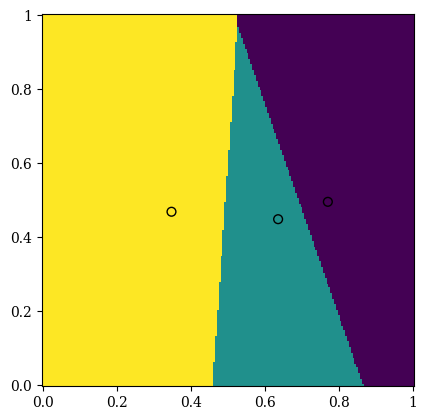

<Figure size 7680x5760 with 0 Axes>

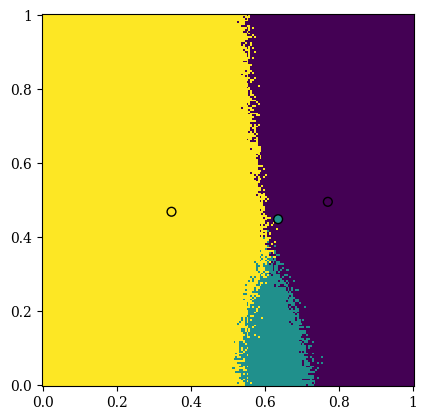

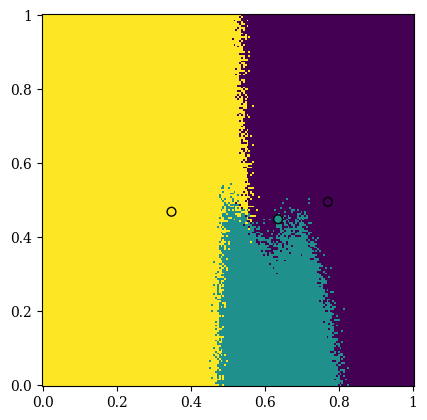

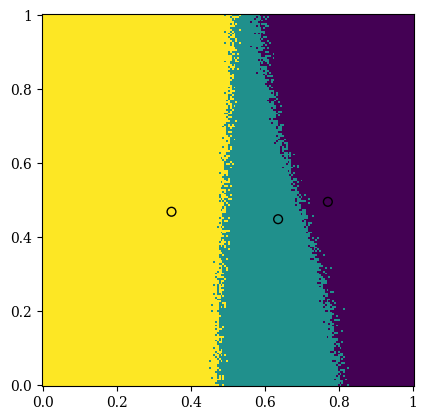

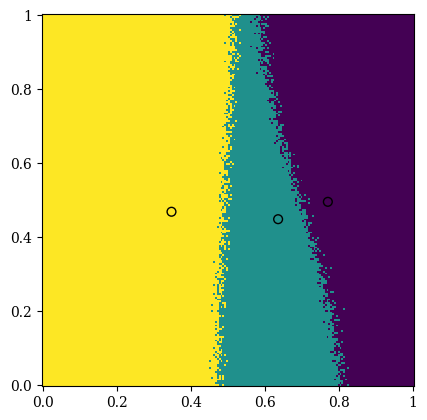

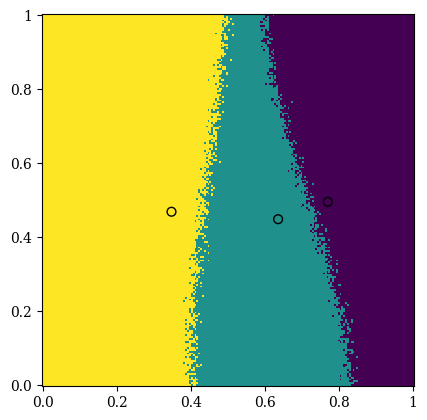

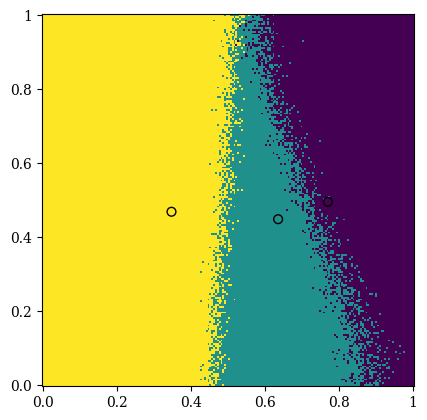

In [4]:
sim1.optimal_win_plot()
election_plot(first_past, sim1)
election_plot(instant_runoff, sim1)
election_plot(condorcet, sim1)
election_plot(baldwin, sim1)
election_plot(borda, sim1)
election_plot(aproval, sim1)

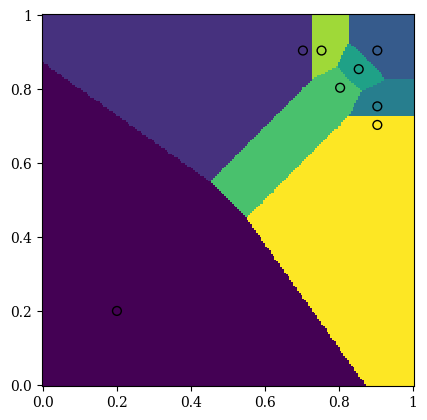

<Figure size 7680x5760 with 0 Axes>

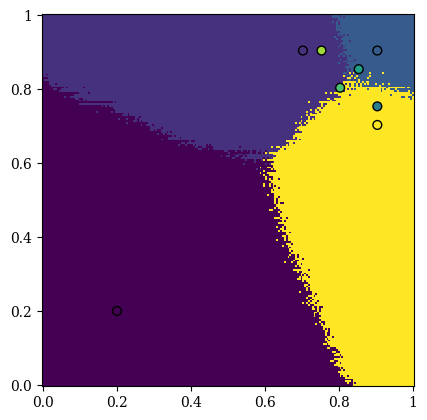

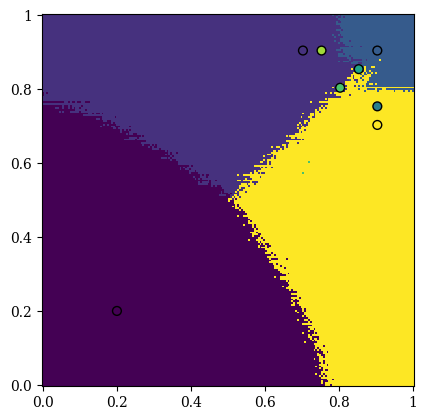

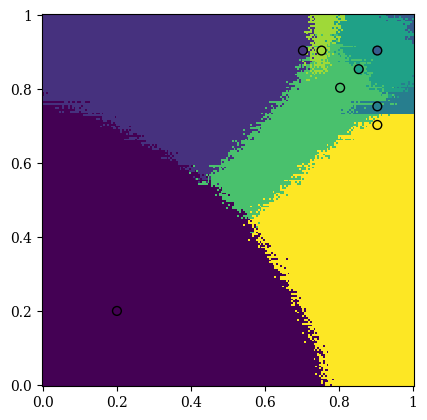

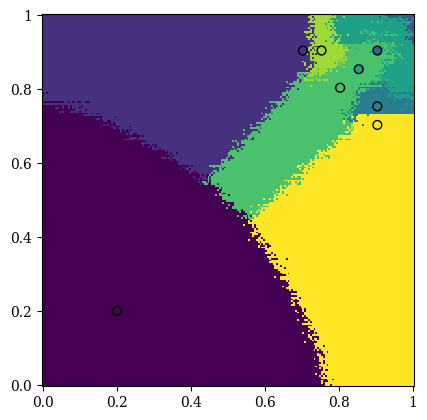

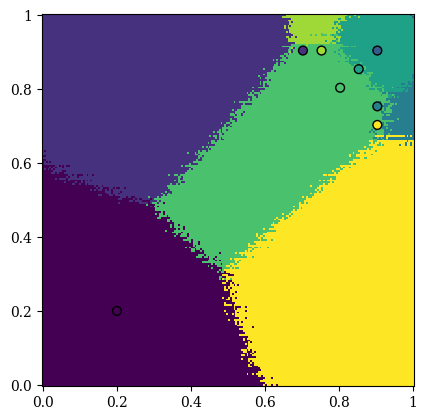

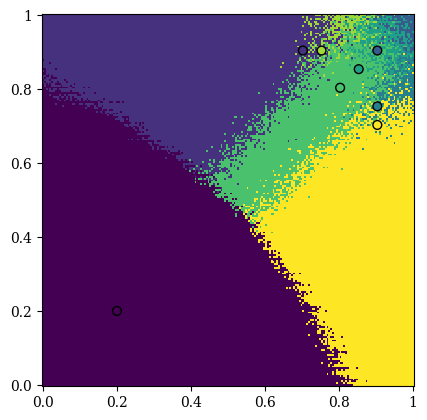

In [5]:
sim2.optimal_win_plot()
election_plot(first_past, sim2)
election_plot(instant_runoff, sim2)
election_plot(condorcet, sim2)
election_plot(baldwin, sim2)
election_plot(borda, sim2)
election_plot(aproval, sim2)